In [1]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 6.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630221 sha256=2baf12aa199de2f16013fdffc4f6c7a787f321bd882ecbbe62fb397732071216
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import surprise
import numpy as np 
import pandas as pd
from surprise import accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os


In [3]:
!unzip /content/drive/MyDrive/goodbooks-10k.zip

Archive:  /content/drive/MyDrive/goodbooks-10k.zip
  inflating: book_tags.csv           
  inflating: books.csv               
  inflating: ratings.csv             
  inflating: sample_book.xml         
  inflating: tags.csv                
  inflating: to_read.csv             


In [6]:
books = pd.read_csv('books.csv')

book_tags = pd.read_csv('tags.csv')

ratings = pd.read_csv('ratings.csv')

tags_data = pd.read_csv('book_tags.csv')

In [7]:
ratings.shape

(981756, 3)

In [8]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [9]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


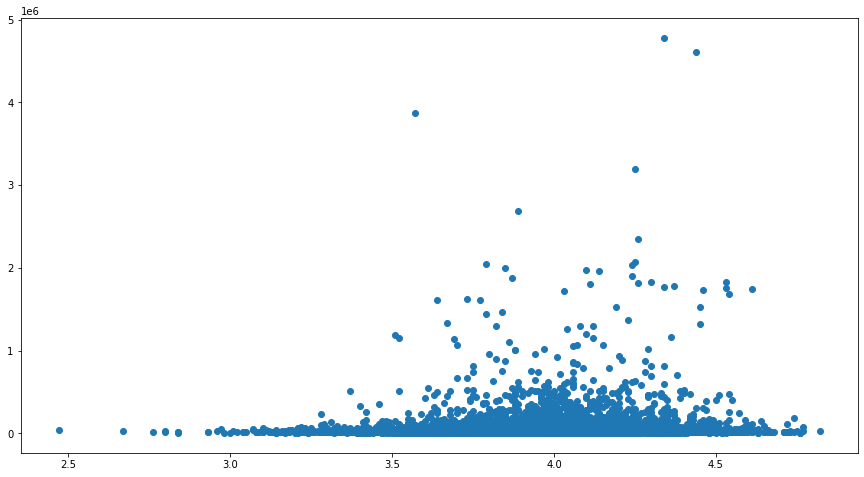

In [10]:
plt.figure(figsize=(15,8))
plt.scatter(x=books['average_rating'], y=books['ratings_count'])

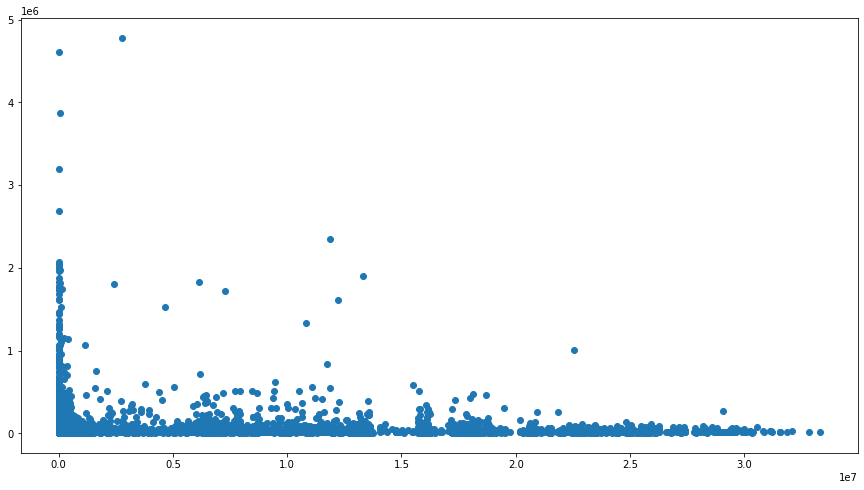

In [45]:
plt.figure(figsize=(15,8))
plt.scatter(x=books['book_id'], y=books['ratings_count'])

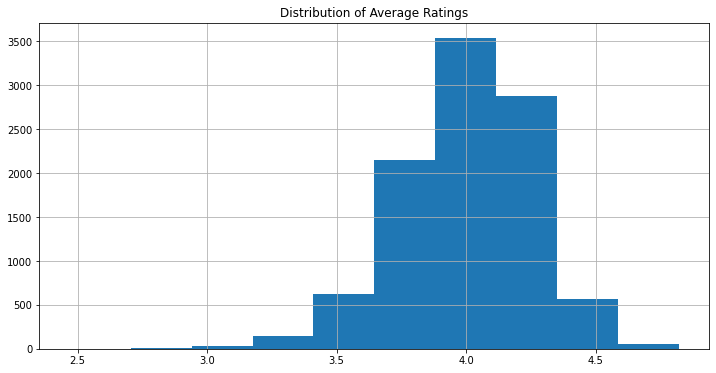

In [49]:
#distribution of average ratings of all the 10000 books
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title("Distribution of Average Ratings")
books["average_rating"].hist()
display()

In [12]:
ratings.drop_duplicates(subset =["user_id","book_id"], keep = False, inplace = True)

In [13]:
ratings.shape

(977269, 3)

In [14]:
raw=pd.read_csv('/content/ratings.csv')

In [15]:
print('we have',raw.shape[0], 'ratings')
print('the number of unique users we have is:', len(raw.user_id.unique()))
print('the number of unique books we have is:', len(raw.book_id.unique()))
print("The median user rated %d books."%raw.user_id.value_counts().median())
print('The max rating is: %d'%raw.rating.max(),"the min rating is: %d"%raw.rating.min())
raw.head()

we have 981756 ratings
the number of unique users we have is: 53424
the number of unique books we have is: 10000
The median user rated 8 books.
The max rating is: 5 the min rating is: 1


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [16]:
raw=raw[['user_id','book_id','rating']] 
raw.columns = ['n_users','n_items','rating']


rawTrain,rawholdout = train_test_split(raw, test_size=0.25 )

In [17]:
reader = surprise.Reader(rating_scale=(1,5))

In [18]:
data = surprise.Dataset.load_from_df(rawTrain,reader)
holdout = surprise.Dataset.load_from_df(rawholdout,reader)

In [19]:
kSplit = surprise.model_selection.split.KFold(n_splits=12, shuffle=True) # split data into folds. 

In [29]:
rmseKNN = []
rmseSVD = []
rmseCoClustering = []
rmseSlope = []
rmseHybrid = []

In [30]:
sim_options = sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
collabKNN = surprise.KNNBasic(k=40,sim_options=sim_options) #try removing sim_options. You'll find memory errors. 

for trainset, testset in kSplit.split(data): #iterate through the folds.
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    rmseKNN.append(surprise.accuracy.rmse(predictionsKNN,verbose=True))#get root means squared error

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8981
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8944
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8968
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8968
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8944
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8962
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9005
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8972
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8972
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9013
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8972
Computing the cosine 

Second Algorithm

In [31]:
SVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)
min_error = 1
for trainset, testset in kSplit.split(data): #iterate through the folds.
    SVD.fit(trainset)
    predictionsSVD = SVD.test(testset)
    rmseSVD.append(surprise.accuracy.rmse(predictionsSVD,verbose=True))#get root means squared error

RMSE: 0.8535
RMSE: 0.8487
RMSE: 0.8561
RMSE: 0.8499
RMSE: 0.8561
RMSE: 0.8493
RMSE: 0.8464
RMSE: 0.8523
RMSE: 0.8530
RMSE: 0.8509
RMSE: 0.8492
RMSE: 0.8489


Third Algorithm

In [32]:
CoClustering = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 
for trainset, testset in kSplit.split(data): #iterate through the folds.
    CoClustering.fit(trainset)
    predictionsCoClustering = CoClustering.test(testset)
    rmseCoClustering.append(surprise.accuracy.rmse(predictionsCoClustering,verbose=True))#get root means squared error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 0.8764
RMSE: 0.8818
RMSE: 0.8896
RMSE: 0.8879
RMSE: 0.8888
RMSE: 0.8852
RMSE: 0.8780
RMSE: 0.8830
RMSE: 0.8865
RMSE: 0.8872
RMSE: 0.8835
RMSE: 0.8853


Fourth Algorithm

In [33]:
slopeOne = surprise.prediction_algorithms.slope_one.SlopeOne()
for trainset, testset in kSplit.split(data): #iterate through the folds.
    slopeOne.fit(trainset)
    predictionsSlope = slopeOne.test(testset)
    rmseSlope.append(surprise.accuracy.rmse(predictionsSlope,verbose=True))#get root means squared error



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 0.9283
RMSE: 0.9243
RMSE: 0.9258
RMSE: 0.9227
RMSE: 0.9217
RMSE: 0.9194
RMSE: 0.9206
RMSE: 0.9245
RMSE: 0.9224
RMSE: 0.9288
RMSE: 0.9206
RMSE: 0.9235


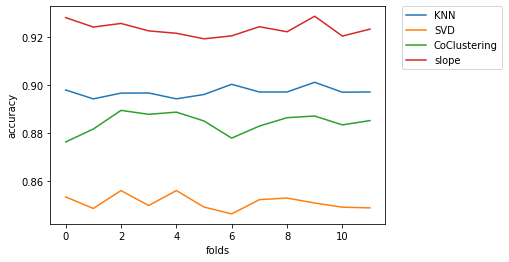

In [34]:
#plotting the prediction data:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(rmseKNN,label='KNN')
modelPrediction = plt.plot(rmseSVD,label='SVD')
modelPrediction = plt.plot(rmseCoClustering,label='CoClustering')
modelPrediction = plt.plot(rmseSlope,label='slope')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [59]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)



class HybridAlgorithm(surprise.AlgoBase):

   
    def __init__(self, epochs, learning_rate, num_models):  #
        self.alpha = np.array([1/len(str(num_models))]*len(str(num_models)))
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit(self,holdout):

        holdout=holdout.build_full_trainset().build_testset()
               
        for epoch in range(self.epochs):
       
            predictions = ([collabKNN.test(holdout),SVD.test(holdout),CoClustering.test(holdout),slopeOne.test(holdout)])

          
            rmseHybrid = [surprise.accuracy.rmse(prediction) for prediction in predictions]
          

              
    def estimate(self,u,i):
       
         if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
           
         algoResults = np.array([collabKNN.predict(u,i),SVD.predict(u,i),CoClustering.predict(u,i),slopeOne.predict(u,i)])

         return np.sum(np.dot(self.alpha,algoResults))



In [ ]:
hybrid = HybridAlgorithm(epochs=10, learning_rate=0.05, num_models=4) #

hybrid.fit(holdout)
rmseHyb = []
for trainset, testset in kSplit.split(data): #iterate through the folds.
    predhybrid = hybrid.test(testset)
    rmseHyb.append(surprise.accuracy.rmse(predhybrid, verbose=True))
